# Aula 1

## Carregando os dados

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['font.size'] = 22

/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/emmanuel/.pyenv/versions/3.6.8/envs/cranium/lib/p

In [2]:
def carregar_dados():
    passageiros = pd.read_csv('Passageiros.csv')
    print(passageiros.head())
    return passageiros

passageiros = carregar_dados()

         tempo  passageiros
0  1949.000000          112
1  1949.083333          118
2  1949.166667          132
3  1949.250000          129
4  1949.333333          121


In [3]:
def plotar_dados_completos():
    sns.lineplot(x='tempo',y='passageiros', data=passageiros,label='dado_completo') 

## Escalando os dados

In [4]:
sc = StandardScaler()
sc.fit(passageiros)
dado_escalado = sc.transform(passageiros)
x_escalado=dado_escalado[:,0] #Features - Características - Tempo
y_escalado=dado_escalado[:,1] #Alvo - Número de passageiros

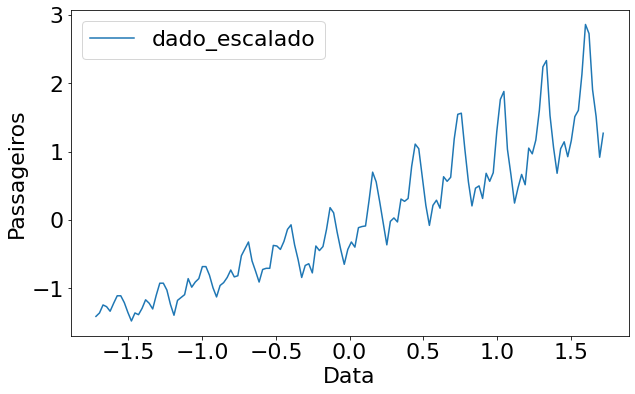

In [5]:
def plotar_eixos(x,y,label):
    sns.lineplot(x=x,y=y,label=label) 
    plt.ylabel('Passageiros')
    plt.xlabel('Data')

    
plotar_eixos(x_escalado, y_escalado, 'dado_escalado')

## Dividindo em treino e teste

In [6]:
def dividir_treino_teste(tamanho_percentual_treino):
    tamanho_treino = int(len(passageiros)*tamanho_percentual_treino) 
    tamanho_teste = int(len(passageiros)-tamanho_treino)
    xtreino = x_escalado[0:tamanho_treino]
    ytreino = y_escalado[0:tamanho_treino]
    xteste = x_escalado[tamanho_treino:len(passageiros)]
    yteste = y_escalado[tamanho_treino:len(passageiros)]
    return xtreino, ytreino, xteste, yteste
    
x_treino, y_treino, x_teste, y_teste = dividir_treino_teste(0.8)

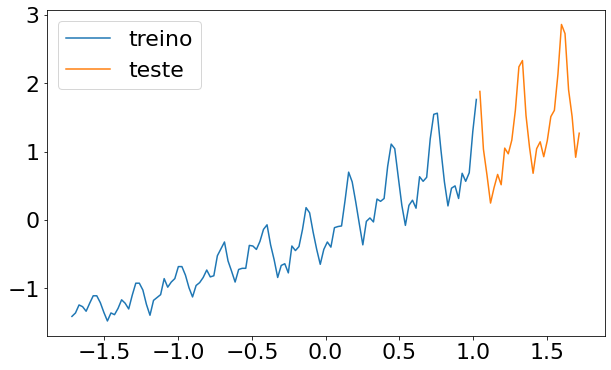

In [7]:
def plotar_eixos(x,y, label):
    sns.lineplot(x=x,y=y,label=label) 

plotar_eixos(x_treino, y_treino, 'treino')    
plotar_eixos(x_teste, y_teste, 'teste')

# Aula 2

## Regressão Linear

In [8]:
def definir_modelo(hyperparams=[], input_dim=1, loss='mean_squared_error', optimizer='adam'):
    
    modelo = Sequential()

    if (hyperparams[0]['input_dim'] is not None):
        input_dim = hyperparams[0]['input_dim']

    for i in range(0, len(hyperparams)):

        modelo.add(Dense(hyperparams[i]['dimensao_saida'],
                         input_dim=input_dim,
                         activation=hyperparams[i]['activation'],
                         kernel_initializer=hyperparams[i]['kernel_initializer'],
                         use_bias=hyperparams[i]['use_bias']))

    modelo.compile(loss=loss,
                   metrics=['accuracy'],
                   optimizer=optimizer)

    modelo.summary()

    return modelo

In [9]:
def plotar_resultados(x, y):
    dados = {'tempo':x, 'passageiros': y[:,0]}
    resultados = pd.DataFrame(data=dados)
    resultados_inversos = sc.inverse_transform(resultados)
    x, y = resultados_inversos[:,0], resultados_inversos[:,1]
    plotar_eixos(x, y, 'predições')

In [10]:
def testar_modelo(hyperparams, epocas_treino=5):
    
    dados = passageiros
        
    modelo = definir_modelo(hyperparams)
    modelo.fit(x_treino, y_treino, epochs=epocas_treino)
    y_predict = modelo.predict(x_treino)
    y_predict_teste = modelo.predict(x_teste)
    
    plotar_dados_completos()
    plotar_resultados(x_treino, y_predict)
    plotar_resultados(x_teste, y_predict_teste)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
115/115 [==============================] - 0s 542us/sample - loss: 0.1017 - acc: 0.0000e+00
Epoch 2/5
115/115 [==============================] - 0s 56us/sample - loss: 0.1010 - acc: 0.0000e+00
Epoch 3/5
115/115 [==============================] - 0s 45us/sample - loss: 0.1004 - acc: 0.0000e+00
Epoch 4/5
115/115 [==============================] - 0s 51us/sample - loss: 0.0998 - acc: 0.0000e+00
Epoch 5/5
115/115 [==============================] - 0s 52us/sample - loss: 0.0993 - acc: 0.0000e+00


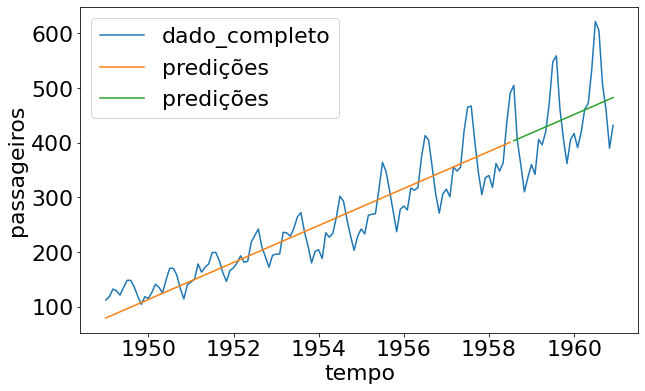

In [11]:
hyperparams_1=[{
    
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'Ones',
    'use_bias':True,
    'input_dim':1
}]

testar_modelo(hyperparams=hyperparams_1)

## Regressão não-linear

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
115/115 [==============================] - 0s 415us/sample - loss: 0.6937 - acc: 0.0000e+00
Epoch 2/500
115/115 [==============================] - 0s 73us/sample - loss: 0.6827 - acc: 0.0000e+00
Epoch 3/500
115/115 [==============================] - 0s 54us/

115/115 [==============================] - 0s 84us/sample - loss: 0.5640 - acc: 0.0000e+00
Epoch 69/500
115/115 [==============================] - 0s 47us/sample - loss: 0.5640 - acc: 0.0000e+00
Epoch 70/500
115/115 [==============================] - 0s 43us/sample - loss: 0.5636 - acc: 0.0000e+00
Epoch 71/500
115/115 [==============================] - 0s 50us/sample - loss: 0.5631 - acc: 0.0000e+00
Epoch 72/500
115/115 [==============================] - 0s 46us/sample - loss: 0.5627 - acc: 0.0000e+00
Epoch 73/500
115/115 [==============================] - 0s 54us/sample - loss: 0.5624 - acc: 0.0000e+00
Epoch 74/500
115/115 [==============================] - 0s 60us/sample - loss: 0.5621 - acc: 0.0000e+00
Epoch 75/500
115/115 [==============================] - 0s 43us/sample - loss: 0.5617 - acc: 0.0000e+00
Epoch 76/500
115/115 [==============================] - 0s 49us/sample - loss: 0.5614 - acc: 0.0000e+00
Epoch 77/500
115/115 [==============================] - 0s 45us/sample - loss

115/115 [==============================] - 0s 51us/sample - loss: 0.5365 - acc: 0.0000e+00
Epoch 147/500
115/115 [==============================] - 0s 53us/sample - loss: 0.5359 - acc: 0.0000e+00
Epoch 148/500
115/115 [==============================] - 0s 55us/sample - loss: 0.5354 - acc: 0.0000e+00
Epoch 149/500
115/115 [==============================] - 0s 52us/sample - loss: 0.5349 - acc: 0.0000e+00
Epoch 150/500
115/115 [==============================] - 0s 56us/sample - loss: 0.5344 - acc: 0.0000e+00
Epoch 151/500
115/115 [==============================] - 0s 45us/sample - loss: 0.5340 - acc: 0.0000e+00
Epoch 152/500
115/115 [==============================] - 0s 46us/sample - loss: 0.5332 - acc: 0.0000e+00
Epoch 153/500
115/115 [==============================] - 0s 43us/sample - loss: 0.5328 - acc: 0.0000e+00
Epoch 154/500
115/115 [==============================] - 0s 52us/sample - loss: 0.5322 - acc: 0.0000e+00
Epoch 155/500
115/115 [==============================] - 0s 42us/samp

115/115 [==============================] - 0s 43us/sample - loss: 0.4878 - acc: 0.0000e+00
Epoch 224/500
115/115 [==============================] - 0s 48us/sample - loss: 0.4866 - acc: 0.0000e+00
Epoch 225/500
115/115 [==============================] - 0s 45us/sample - loss: 0.4859 - acc: 0.0000e+00
Epoch 226/500
115/115 [==============================] - 0s 58us/sample - loss: 0.4850 - acc: 0.0000e+00
Epoch 227/500
115/115 [==============================] - 0s 46us/sample - loss: 0.4844 - acc: 0.0000e+00
Epoch 228/500
115/115 [==============================] - 0s 62us/sample - loss: 0.4836 - acc: 0.0000e+00
Epoch 229/500
115/115 [==============================] - 0s 44us/sample - loss: 0.4831 - acc: 0.0000e+00
Epoch 230/500
115/115 [==============================] - 0s 57us/sample - loss: 0.4821 - acc: 0.0000e+00
Epoch 231/500
115/115 [==============================] - 0s 46us/sample - loss: 0.4814 - acc: 0.0000e+00
Epoch 232/500
115/115 [==============================] - 0s 54us/samp

115/115 [==============================] - 0s 50us/sample - loss: 0.4246 - acc: 0.0000e+00
Epoch 302/500
115/115 [==============================] - 0s 51us/sample - loss: 0.4238 - acc: 0.0000e+00
Epoch 303/500
115/115 [==============================] - 0s 48us/sample - loss: 0.4229 - acc: 0.0000e+00
Epoch 304/500
115/115 [==============================] - 0s 47us/sample - loss: 0.4222 - acc: 0.0000e+00
Epoch 305/500
115/115 [==============================] - 0s 44us/sample - loss: 0.4213 - acc: 0.0000e+00
Epoch 306/500
115/115 [==============================] - 0s 47us/sample - loss: 0.4204 - acc: 0.0000e+00
Epoch 307/500
115/115 [==============================] - 0s 47us/sample - loss: 0.4196 - acc: 0.0000e+00
Epoch 308/500
115/115 [==============================] - 0s 64us/sample - loss: 0.4188 - acc: 0.0000e+00
Epoch 309/500
115/115 [==============================] - 0s 46us/sample - loss: 0.4180 - acc: 0.0000e+00
Epoch 310/500
115/115 [==============================] - 0s 45us/samp

115/115 [==============================] - 0s 61us/sample - loss: 0.3601 - acc: 0.0000e+00
Epoch 379/500
115/115 [==============================] - 0s 47us/sample - loss: 0.3592 - acc: 0.0000e+00
Epoch 380/500
115/115 [==============================] - 0s 47us/sample - loss: 0.3584 - acc: 0.0000e+00
Epoch 381/500
115/115 [==============================] - 0s 50us/sample - loss: 0.3576 - acc: 0.0000e+00
Epoch 382/500
115/115 [==============================] - 0s 56us/sample - loss: 0.3568 - acc: 0.0000e+00
Epoch 383/500
115/115 [==============================] - 0s 44us/sample - loss: 0.3559 - acc: 0.0000e+00
Epoch 384/500
115/115 [==============================] - 0s 42us/sample - loss: 0.3552 - acc: 0.0000e+00
Epoch 385/500
115/115 [==============================] - 0s 63us/sample - loss: 0.3545 - acc: 0.0000e+00
Epoch 386/500
115/115 [==============================] - 0s 67us/sample - loss: 0.3535 - acc: 0.0000e+00
Epoch 387/500
115/115 [==============================] - 0s 48us/samp

115/115 [==============================] - 0s 47us/sample - loss: 0.2986 - acc: 0.0000e+00
Epoch 457/500
115/115 [==============================] - 0s 47us/sample - loss: 0.2978 - acc: 0.0000e+00
Epoch 458/500
115/115 [==============================] - 0s 53us/sample - loss: 0.2971 - acc: 0.0000e+00
Epoch 459/500
115/115 [==============================] - 0s 43us/sample - loss: 0.2964 - acc: 0.0000e+00
Epoch 460/500
115/115 [==============================] - 0s 53us/sample - loss: 0.2956 - acc: 0.0000e+00
Epoch 461/500
115/115 [==============================] - 0s 47us/sample - loss: 0.2950 - acc: 0.0000e+00
Epoch 462/500
115/115 [==============================] - 0s 48us/sample - loss: 0.2941 - acc: 0.0000e+00
Epoch 463/500
115/115 [==============================] - 0s 45us/sample - loss: 0.2933 - acc: 0.0000e+00
Epoch 464/500
115/115 [==============================] - 0s 49us/sample - loss: 0.2926 - acc: 0.0000e+00
Epoch 465/500
115/115 [==============================] - 0s 61us/samp

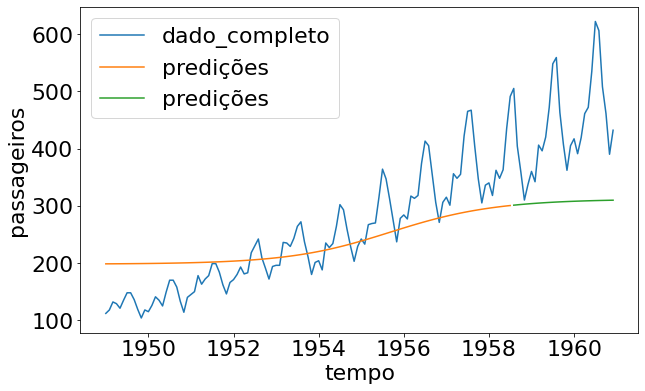

In [12]:
hyperparams_4 = [{
    
    'dimensao_saida':8,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    'input_dim':1
    
},


{
    'dimensao_saida':8,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False
    
},
    
    {
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False
    
}

]

testar_modelo(hyperparams_4, epocas_treino=500)

# Aula 3

## Alterando a forma como passamos os dados

Agora x e y vão valores diferentes. X vai conter o número de passageiros em um tempo anterior e y vai conter o número de passageiros em t+1, por exemplo. 

In [13]:
def separa_dados(dados_seriados, n_passos):
    
  """Entrada: vetor: número de passageiros
               n_passos: número de passos no regressor
     Saída:
              X_novo: Array 2D 
              y_novo: Array 1D - Nosso alvo
  """
  vetor = pd.DataFrame(dados_seriados)[0]
  X_novo, y_novo = [], []
  for i in range(n_passos,vetor.shape[0]):
    X_novo.append(list(vetor.loc[i-n_passos:i-1]))
    y_novo.append(vetor.loc[i])
  X_novo, y_novo = np.array(X_novo), np.array(y_novo) 
  return X_novo, y_novo

In [14]:
n_passos = 1
xtreino_novo, ytreino_novo = separa_dados(y_treino, n_passos)
xteste_novo, yteste_novo = separa_dados(y_teste, n_passos)

## Agora vamos separar o teste

## Voltando para as redes neurais

In [15]:
hyperparams_5 = [{
    
    'dimensao_saida':8,
   'activation':'linear',
    'kernel_initializer':'ones',
    'use_bias':False,
    'input_dim':n_passos
    
},


{
    'dimensao_saida':64,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
},
    
    {
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
}



]

regressor3 = definir_modelo(hyperparams_5)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 8         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 64        
Total params: 584
Trainable params: 584
Non-trainable params: 0
_________________________________________________________________


In [16]:
regressor3.fit(xtreino_novo,ytreino_novo,epochs =100)

Epoch 1/100
114/114 [==============================] - 0s 408us/sample - loss: 0.9008 - acc: 0.0000e+00
Epoch 2/100
114/114 [==============================] - 0s 68us/sample - loss: 0.7529 - acc: 0.0000e+00
Epoch 3/100
114/114 [==============================] - 0s 74us/sample - loss: 0.6440 - acc: 0.0000e+00
Epoch 4/100
114/114 [==============================] - 0s 86us/sample - loss: 0.5707 - acc: 0.0000e+00
Epoch 5/100
114/114 [==============================] - 0s 86us/sample - loss: 0.5298 - acc: 0.0000e+00
Epoch 6/100
114/114 [==============================] - 0s 105us/sample - loss: 0.5029 - acc: 0.0000e+00
Epoch 7/100
114/114 [==============================] - 0s 65us/sample - loss: 0.4937 - acc: 0.0000e+00
Epoch 8/100
114/114 [==============================] - 0s 52us/sample - loss: 0.4883 - acc: 0.0000e+00
Epoch 9/100
114/114 [==============================] - 0s 57us/sample - loss: 0.4801 - acc: 0.0000e+00
Epoch 10/100
114/114 [==============================] - 0s 94us/sample 

114/114 [==============================] - 0s 55us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 80/100
114/114 [==============================] - 0s 56us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 81/100
114/114 [==============================] - 0s 51us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 82/100
114/114 [==============================] - 0s 55us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 83/100
114/114 [==============================] - 0s 53us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 84/100
114/114 [==============================] - 0s 49us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 85/100
114/114 [==============================] - 0s 52us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 86/100
114/114 [==============================] - 0s 57us/sample - loss: 0.0507 - acc: 0.0000e+00
Epoch 87/100
114/114 [==============================] - 0s 66us/sample - loss: 0.0506 - acc: 0.0000e+00
Epoch 88/100
114/114 [==============================] - 0s 48us/sample - loss

In [17]:
y_predict_novo = regressor3.predict(xtreino_novo)

In [18]:
def plotar_resultado_treino_dados_alterados(y, dados, label):
    sns.lineplot(x='tempo',y=y,data=dados,label=label)

In [19]:
y_predict_teste_novo = regressor3.predict(xteste_novo)

In [20]:
resultado = pd.DataFrame(y_predict_teste_novo)[0]

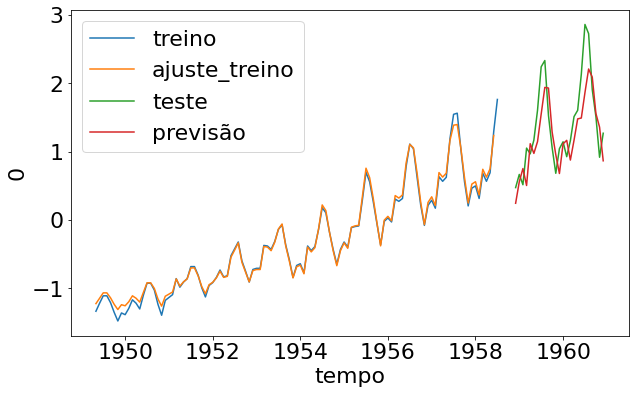

In [32]:
def plotar_resultados_2():
    inicio = passageiros.shape[0] - yteste_novo.shape[0]
    fim = passageiros.shape[0]
    fim_2 = ytreino_novo.shape[0] + n_passos
    plotar_resultado_treino_dados_alterados(ytreino_novo, passageiros[n_passos:fim_2], 'treino')
    plotar_resultado_treino_dados_alterados(pd.DataFrame(y_predict_novo)[0], passageiros[n_passos:fim_2],
                                            'ajuste_treino')
    plotar_resultado_treino_dados_alterados(yteste_novo, passageiros[inicio:fim], 'teste')
    plotar_resultado_treino_dados_alterados(resultado.values, passageiros[inicio:fim], 'previsão')

plotar_resultados_2()

## Janelas

In [22]:
n_passos = 4
xtreino_novo, ytreino_novo = separa_dados(y_treino, n_passos)
xteste_novo, yteste_novo = separa_dados(y_teste, n_passos)

In [23]:
hyperparams_6 = [{
    
    
    'dimensao_saida':8,
   'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    'input_dim':n_passos
    
},


{
    'dimensao_saida':64,
   'activation':'sigmoid',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
},
    
    {
    'dimensao_saida':1,
    'activation':'linear',
    'kernel_initializer':'random_uniform',
    'use_bias':False,
    
}



]

regressor4 = definir_modelo(hyperparams_6)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8)                 32        
_________________________________________________________________
dense_8 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 64        
Total params: 608
Trainable params: 608
Non-trainable params: 0
_________________________________________________________________


In [24]:
regressor4.fit(xtreino_novo,ytreino_novo,epochs =300)

Epoch 1/300
111/111 [==============================] - 0s 452us/sample - loss: 0.6416 - acc: 0.0000e+00
Epoch 2/300
111/111 [==============================] - 0s 71us/sample - loss: 0.5898 - acc: 0.0000e+00
Epoch 3/300
111/111 [==============================] - 0s 73us/sample - loss: 0.5628 - acc: 0.0000e+00
Epoch 4/300
111/111 [==============================] - 0s 65us/sample - loss: 0.5584 - acc: 0.0000e+00
Epoch 5/300
111/111 [==============================] - 0s 58us/sample - loss: 0.5609 - acc: 0.0000e+00
Epoch 6/300
111/111 [==============================] - 0s 83us/sample - loss: 0.5635 - acc: 0.0000e+00
Epoch 7/300
111/111 [==============================] - 0s 75us/sample - loss: 0.5589 - acc: 0.0000e+00
Epoch 8/300
111/111 [==============================] - 0s 72us/sample - loss: 0.5522 - acc: 0.0000e+00
Epoch 9/300
111/111 [==============================] - 0s 65us/sample - loss: 0.5459 - acc: 0.0000e+00
Epoch 10/300
111/111 [==============================] - 0s 65us/sample -

111/111 [==============================] - 0s 72us/sample - loss: 0.0910 - acc: 0.0000e+00
Epoch 80/300
111/111 [==============================] - 0s 68us/sample - loss: 0.0905 - acc: 0.0000e+00
Epoch 81/300
111/111 [==============================] - 0s 64us/sample - loss: 0.0899 - acc: 0.0000e+00
Epoch 82/300
111/111 [==============================] - 0s 57us/sample - loss: 0.0895 - acc: 0.0000e+00
Epoch 83/300
111/111 [==============================] - 0s 58us/sample - loss: 0.0890 - acc: 0.0000e+00
Epoch 84/300
111/111 [==============================] - 0s 50us/sample - loss: 0.0886 - acc: 0.0000e+00
Epoch 85/300
111/111 [==============================] - 0s 57us/sample - loss: 0.0879 - acc: 0.0000e+00
Epoch 86/300
111/111 [==============================] - 0s 56us/sample - loss: 0.0877 - acc: 0.0000e+00
Epoch 87/300
111/111 [==============================] - 0s 58us/sample - loss: 0.0873 - acc: 0.0000e+00
Epoch 88/300
111/111 [==============================] - 0s 55us/sample - loss

111/111 [==============================] - 0s 55us/sample - loss: 0.0591 - acc: 0.0000e+00
Epoch 158/300
111/111 [==============================] - 0s 66us/sample - loss: 0.0589 - acc: 0.0000e+00
Epoch 159/300
111/111 [==============================] - 0s 59us/sample - loss: 0.0586 - acc: 0.0000e+00
Epoch 160/300
111/111 [==============================] - 0s 80us/sample - loss: 0.0585 - acc: 0.0000e+00
Epoch 161/300
111/111 [==============================] - 0s 54us/sample - loss: 0.0582 - acc: 0.0000e+00
Epoch 162/300
111/111 [==============================] - 0s 67us/sample - loss: 0.0580 - acc: 0.0000e+00
Epoch 163/300
111/111 [==============================] - 0s 52us/sample - loss: 0.0578 - acc: 0.0000e+00
Epoch 164/300
111/111 [==============================] - 0s 68us/sample - loss: 0.0577 - acc: 0.0000e+00
Epoch 165/300
111/111 [==============================] - 0s 57us/sample - loss: 0.0574 - acc: 0.0000e+00
Epoch 166/300
111/111 [==============================] - 0s 58us/samp

111/111 [==============================] - 0s 88us/sample - loss: 0.0500 - acc: 0.0000e+00
Epoch 236/300
111/111 [==============================] - 0s 106us/sample - loss: 0.0501 - acc: 0.0000e+00
Epoch 237/300
111/111 [==============================] - 0s 61us/sample - loss: 0.0508 - acc: 0.0000e+00
Epoch 238/300
111/111 [==============================] - 0s 55us/sample - loss: 0.0504 - acc: 0.0000e+00
Epoch 239/300
111/111 [==============================] - 0s 56us/sample - loss: 0.0501 - acc: 0.0000e+00
Epoch 240/300
111/111 [==============================] - 0s 53us/sample - loss: 0.0505 - acc: 0.0000e+00
Epoch 241/300
111/111 [==============================] - 0s 107us/sample - loss: 0.0502 - acc: 0.0000e+00
Epoch 242/300
111/111 [==============================] - 0s 88us/sample - loss: 0.0496 - acc: 0.0000e+00
Epoch 243/300
111/111 [==============================] - 0s 56us/sample - loss: 0.0500 - acc: 0.0000e+00
Epoch 244/300
111/111 [==============================] - 0s 66us/sa

In [25]:
y_predict_teste_novo = regressor4.predict(xteste_novo)

In [26]:
resultado = pd.DataFrame(y_predict_teste_novo)[0]

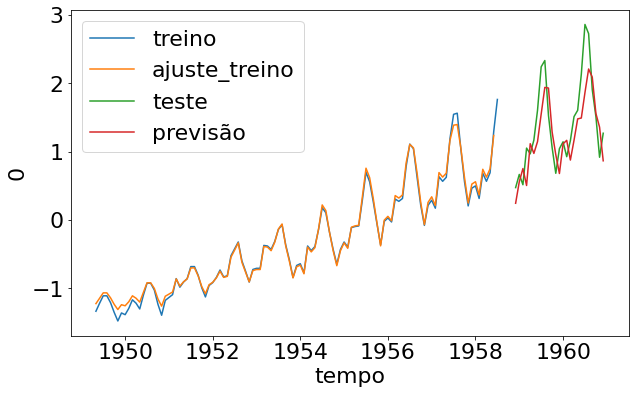

In [31]:
plotar_resultados_2()